In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import nengo
import numpy as np
import Odorant_Stim
import scipy.interpolate

In [2]:
#r = list(csv.reader(open('erecta_picky_circuitry_absolute.csv')))
r = list(csv.reader(open('melanogaster_picky_circuitry_absolute.csv')))

header = r[0]
data = r[1:]

conns = {}
for row in data:
    for i, item in enumerate(row):
        if i > 0:
            pre = row[0]
            post = header[i]
            c = int(item)
            if c > 0:
                if pre not in conns:
                    conns[pre] = {}
                conns[pre][post] = c


In [3]:
def compute_rate_to_current(neuron_model=nengo.LIFRate(), max_current=10.0):
    tuning_model = nengo.Network()
    with tuning_model:
        N = 1
        T = 10
        max_current = 10.0
        n = nengo.Ensemble(n_neurons=N, dimensions=1,
                           neuron_type=nengo.LIFRate(),
                           gain=[1]*N, bias=[0]*N,
                           )

        stim = nengo.Node(lambda t: t/T*max_current)
        nengo.Connection(stim, n.neurons, transform=np.ones((N, 1)), synapse=None)
        p_rate = nengo.Probe(n.neurons)
        p_current = nengo.Probe(stim)
    sim = nengo.Simulator(tuning_model, progress_bar=False)
    with sim:
        sim.run(T)
    rate_to_current = scipy.interpolate.interp1d(sim.data[p_rate][:,0], sim.data[p_current][:,0])
    return rate_to_current


rate_to_current = compute_rate_to_current()

/opt/anaconda3/lib/python3.8/site-packages/nengo/neurons.py:580: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


In [4]:
ORNs_left = [name for name in header if 'ORN' in name and 'left' in name]
ORNs_right = [name for name in header if 'ORN' in name and 'right' in name]
uPNs_left = [name for name in header if ' PN' in name and 'left' in name]
uPNs_right = [name for name in header if ' PN' in name and 'right' in name]
mPNs_left = [name for name in header if 'mPN' in name and 'left' in name]
mPNs_right = [name for name in header if 'mPN' in name and 'right' in name]
Pickys_left = [name for name in header if 'icky' in name and 'left' in name]
Pickys_right = [name for name in header if 'icky' in name and 'right' in name]

assert (len(ORNs_left)+len(ORNs_right)+len(uPNs_left)+len(uPNs_right)+
        len(mPNs_left)+len(mPNs_right)+len(Pickys_left)+len(Pickys_right) == len(header)-1)


In [43]:

def make_weights(pre, post):
    w = np.zeros((len(post), len(pre))) #note: pre/post switched in output array for print(make_weights())
    for i, pre_n in enumerate(pre):
        for j, post_n in enumerate(post):
            if post_n in conns[pre_n]:
                w[j,i] = conns[pre_n][post_n] 
    return w

model = nengo.Network()
with model:
    stims = [-20,-20,-2,-20,-20]
    log_concentrations = nengo.Node(nengo.processes.PresentInput(stims, presentation_time=5))

    def logconc_to_conc_func(t, x):              
        return 10**x     
    concentrations = nengo.Node(logconc_to_conc_func, size_in=1)

    def OR_func(t, x):
        rel = Odorant_Stim.convert_compounds_to_responses(x)     
        max_rate = 35  # [100, 90, 97, 18, 30, ...]
        background_rate = 6   # [6, 8, 1, 3, ...]
        return rate_to_current(rel*max_rate+background_rate) #you get an error when conc are increased and the max_rate is too high
        
    l_ORN_current = nengo.Node(OR_func, size_in=3)
    l_ORN = nengo.Ensemble(n_neurons=len(ORNs_left), dimensions=1,
                           neuron_type=nengo.LIF(),
                           noise=nengo.processes.WhiteNoise(nengo.dists.Gaussian(0,0.02)),
                           gain=[1]*len(ORNs_left), bias=[0]*len(ORNs_left))
    nengo.Connection(l_ORN_current, l_ORN.neurons, synapse=None)
    l_uPN = nengo.Ensemble(n_neurons=len(uPNs_left), dimensions=1,
                           gain=np.ones(len(uPNs_left)), bias=np.zeros(len(uPNs_left)))
    l_mPN = nengo.Ensemble(n_neurons=len(mPNs_left), dimensions=1,
                           gain=np.ones(len(mPNs_left)), bias=np.zeros(len(mPNs_left)))
    l_Picky = nengo.Ensemble(n_neurons=len(Pickys_left), dimensions=1,
                           gain=np.ones(len(Pickys_left)), bias=np.zeros(len(Pickys_left)))
    
    nengo.Connection(log_concentrations, concentrations, synapse=None)
    nengo.Connection(concentrations, l_ORN_current[1], synapse=nengo.synapses.Alpha(1))
    nengo.Connection(nengo.Node(0), l_ORN_current[0], synapse=None)
    nengo.Connection(nengo.Node(0), l_ORN_current[2], synapse=None)
    
    #noise = nengo.Node(nengo.processes.WhiteNoise(nengo.dists.Gaussian(0,1)))
    #p_noise = nengo.Probe(noise)
    #noise2 = nengo.Node(nengo.processes.WhiteSignal(period=100, high=2))
    #p_noise2 = nengo.Probe(noise2)
    
    nengo.Connection(l_ORN.neurons, l_uPN.neurons, 
                     transform=0.002*make_weights(ORNs_left, uPNs_left), 
                     synapse=0.01)
    nengo.Connection(l_ORN.neurons, l_mPN.neurons, 
                     transform=0.002*make_weights(ORNs_left, mPNs_left),
                     synapse=0.01)
    nengo.Connection(l_ORN.neurons, l_Picky.neurons, 
                     transform=0.0005*make_weights(ORNs_left, Pickys_left),
                     synapse=0.01)
    nengo.Connection(l_Picky.neurons, l_uPN.neurons, 
                     transform=-0.05*make_weights(Pickys_left, uPNs_left),
                     synapse=0.01)
    nengo.Connection(l_Picky.neurons, l_mPN.neurons, 
                     transform=-0.05*make_weights(Pickys_left, mPNs_left),
                     synapse=0.01)
    
    p_Picky = nengo.Probe(l_Picky.neurons)
    p_stim = nengo.Probe(concentrations)
    p_uPN = nengo.Probe(l_uPN.neurons)
    p_mPN = nengo.Probe(l_mPN.neurons)
    p_ORN = nengo.Probe(l_ORN.neurons)
    
    
sim = nengo.Simulator(model)
sim.run(25)
    
    

/opt/anaconda3/lib/python3.8/site-packages/nengo/neurons.py:580: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

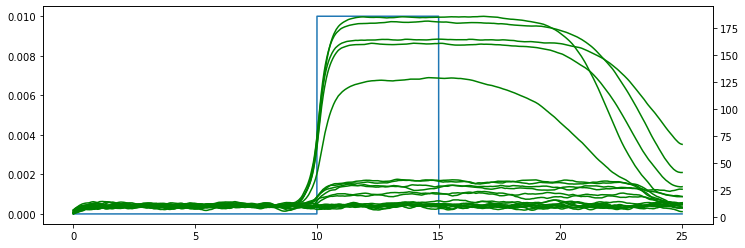

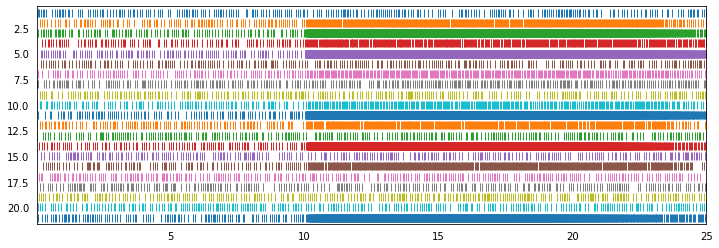

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_stim])
plt.twinx()

filt = nengo.synapses.Lowpass(0.3)
plt.plot(sim.trange(), filt.filtfilt(sim.data[p_ORN]), c='g')
#plt.savefig('OSN_temporal_dynamics_-6.png')
plt.show()

import nengo.utils.matplotlib
plt.figure(figsize=(12,4))
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_ORN])
plt.show()

In [46]:
data_ORN = sim.data[p_ORN]
data_uPN = sim.data[p_uPN]
data_mPN = sim.data[p_mPN]
data_Picky = sim.data[p_Picky]

#for i in range(21):
    

def calc_spike_frequency(data_neurons):
    total_spikes = np.zeros((50, len(data_neurons[0][:])))
    spike_rate = np.zeros((len(data_neurons[0][:]), 50, 2))

    for i in range(50):
        for ms, row in enumerate(data_neurons):
            if ms >= (500*i) and ms < 500 + (500*i):  
                for p, activity in enumerate(row):
                    if data_neurons[ms, p] == 1000:
                        total_spikes[i, p] += 1 
        if i <= 30 and b > 20:
            spike_rate[:, b, 0] = -6
        else:
            spike_rate[:, b, 0] = -20
    for x, row in enumerate(total_spikes):
        for y, spikes in enumerate(row):
            spike_rate[y, x, 1] = (total_spikes[x][y])/0.5
    return spike_rate
            
#print(calc_spike_frequency(data_uPN)[13:26])

a = len((data_uPN[0][:]))
b = len((data_mPN[0][:]))
c = len((data_Picky[0][:]))
   

concentrations_range_uPN = np.zeros((a, 50))
concentrations_range_mPN = np.zeros((a, 50))
concentrations_range_picky = np.zeros((a, 50))
responses_GA_ORN = np.zeros((a, 50))
responses_GA_uPN = np.zeros((a, 50))
responses_GA_mPN = np.zeros((b, 50))
responses_GA_picky = np.zeros((c, 50))
for i in range(a):
    for j, activity in enumerate(calc_spike_frequency(data_uPN)[i]):
        responses_GA_uPN[i,j] += activity[1]
        concentrations_range_uPN[i, j] += activity[0]
    for j, activity in enumerate(calc_spike_frequency(data_ORN)[i]):
        responses_GA_ORN[i,j] += activity[1]
            
for i in range(b):
    for j, activity in enumerate(calc_spike_frequency(data_mPN)[i]):
        responses_GA_mPN[i,j] += activity[1]
        concentrations_range_mPN[i, j] += activity[0]
          
for i in range(c):
    for j, activity in enumerate(calc_spike_frequency(data_Picky)[i]):
        responses_GA_picky[i,j] += activity[1]
        concentrations_range_picky[i, j] += activity[0]

In [33]:
responses_GA_ORN

array([[ 8., 14.,  8., ..., 12., 14., 12.],
       [ 8.,  8., 10., ..., 10., 10., 12.],
       [10., 10., 10., ..., 10., 10.,  8.],
       ...,
       [12., 12.,  6., ..., 14.,  8., 10.],
       [ 6.,  6., 14., ...,  8., 12.,  8.],
       [10.,  8.,  6., ..., 10., 12., 14.]])

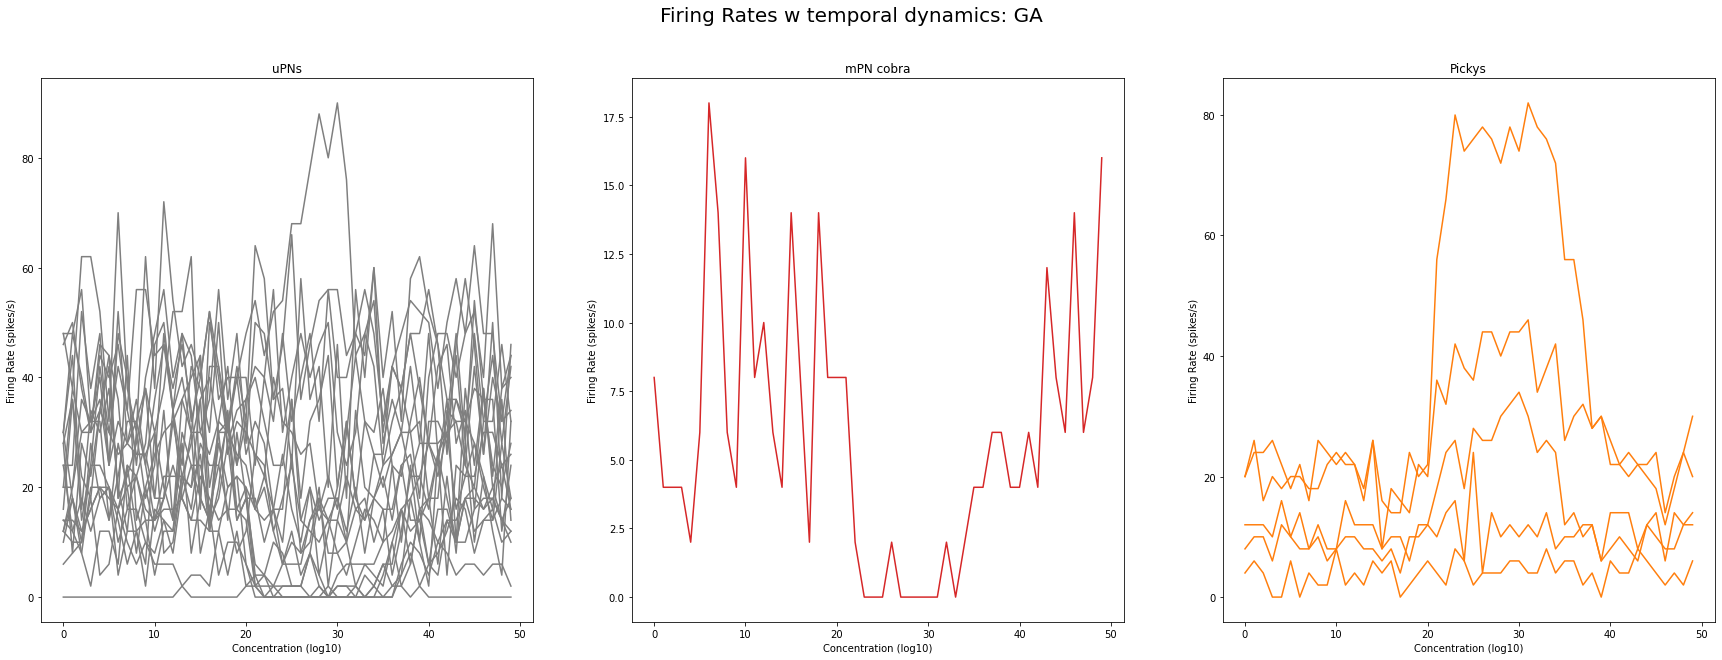

In [34]:
#plot spike behaviour
%matplotlib inline
import matplotlib.pyplot as plt
    
fig, axs = plt.subplots(1,3, figsize=(30, 10))
fig.suptitle('Firing Rates w temporal dynamics: GA', fontsize = 20)
for ax in axs.flat:
        ax.set(xlabel='Concentration (log10)', ylabel='Firing Rate (spikes/s)')

#x_list = concentrations_range_uPN, concentrations_range_mPN, concentrations_range_picky
x_list = list(range(0, 50))
y_list_GA = responses_GA_uPN, responses_GA_mPN, responses_GA_picky
color_list = 'tab:gray', 'tab:red', 'tab:orange'

for i in range(a):
    axs[0].plot(x_list, y_list_GA[0][i], color=color_list[0])

for i in range(b):
    axs[1].plot(x_list, y_list_GA[1][i], color=color_list[1])

for i in range(c):
    axs[2].plot(x_list, y_list_GA[2][i], color=color_list[2])

axs[0].set_title('uPNs')
axs[1].set_title('mPN cobra')
axs[2].set_title('Pickys')

#plt.savefig('Firing_Rates_tempdynamics_sim_not great pikcy only.png')
plt.show()

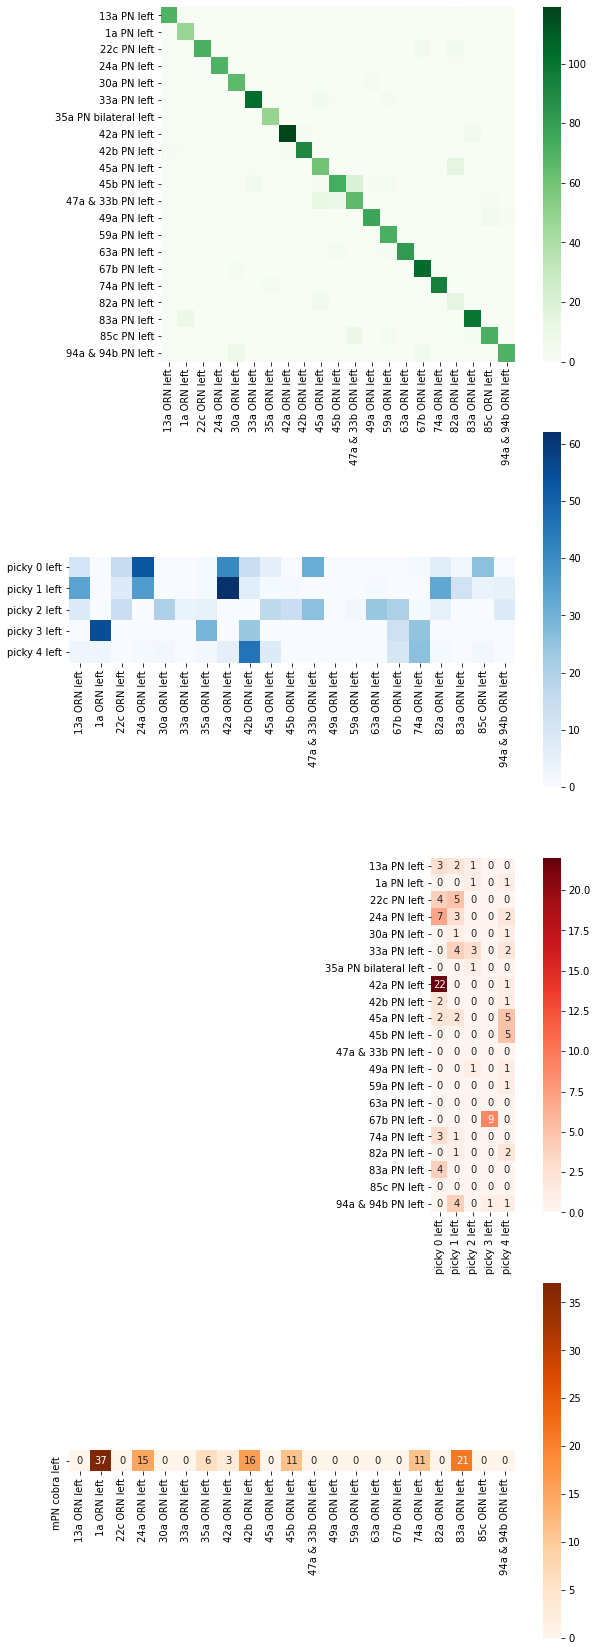

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,30))
title = 'Heatmap GA'
sns.heatmap(make_weights(ORNs_left, uPNs_left), cmap='Greens', xticklabels=ORNs_left, yticklabels= uPNs_left, ax=ax1, square=True)
sns.heatmap(make_weights(ORNs_left, Pickys_left), cmap='Blues', xticklabels=ORNs_left, yticklabels= Pickys_left, ax=ax2, square=True)
sns.heatmap(make_weights(Pickys_left, uPNs_left), cmap='Reds', xticklabels=Pickys_left, yticklabels= uPNs_left, ax=ax3, square=True, annot=True)
sns.heatmap(make_weights(ORNs_left, mPNs_left), cmap='Oranges', xticklabels=ORNs_left, yticklabels= mPNs_left, ax=ax4, square=True, annot=True)
plt.show()

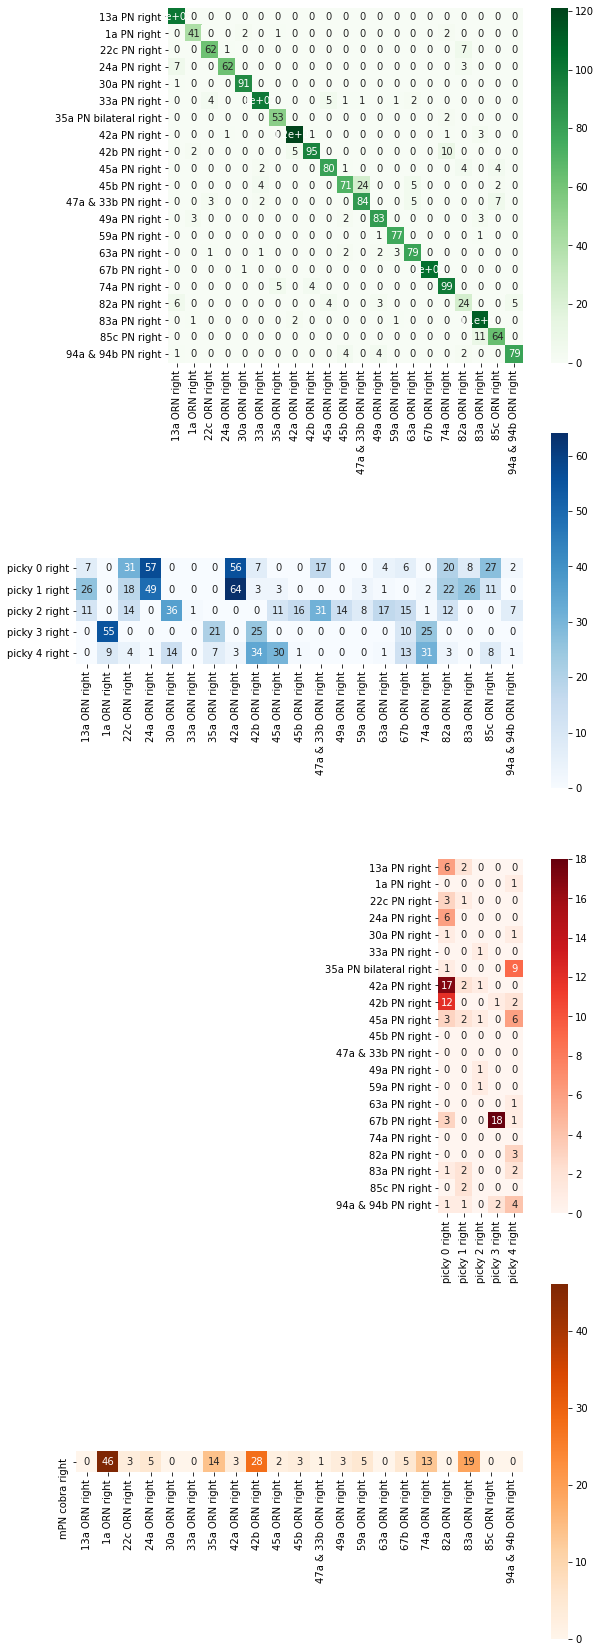

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,30))
title = 'Heatmap GA'
sns.heatmap(make_weights(ORNs_right, uPNs_right), cmap='Greens', xticklabels=ORNs_right, yticklabels= uPNs_right, ax=ax1, square=True, annot= True)
sns.heatmap(make_weights(ORNs_right, Pickys_right), cmap='Blues', xticklabels=ORNs_right, yticklabels= Pickys_right, ax=ax2, square=True, annot= True)
sns.heatmap(make_weights(Pickys_right, uPNs_right), cmap='Reds', xticklabels=Pickys_right, yticklabels= uPNs_right, ax=ax3, square=True, annot= True)
sns.heatmap(make_weights(ORNs_right, mPNs_right), cmap='Oranges', xticklabels=ORNs_right, yticklabels= mPNs_right, ax=ax4, square=True, annot=True)
plt.show()

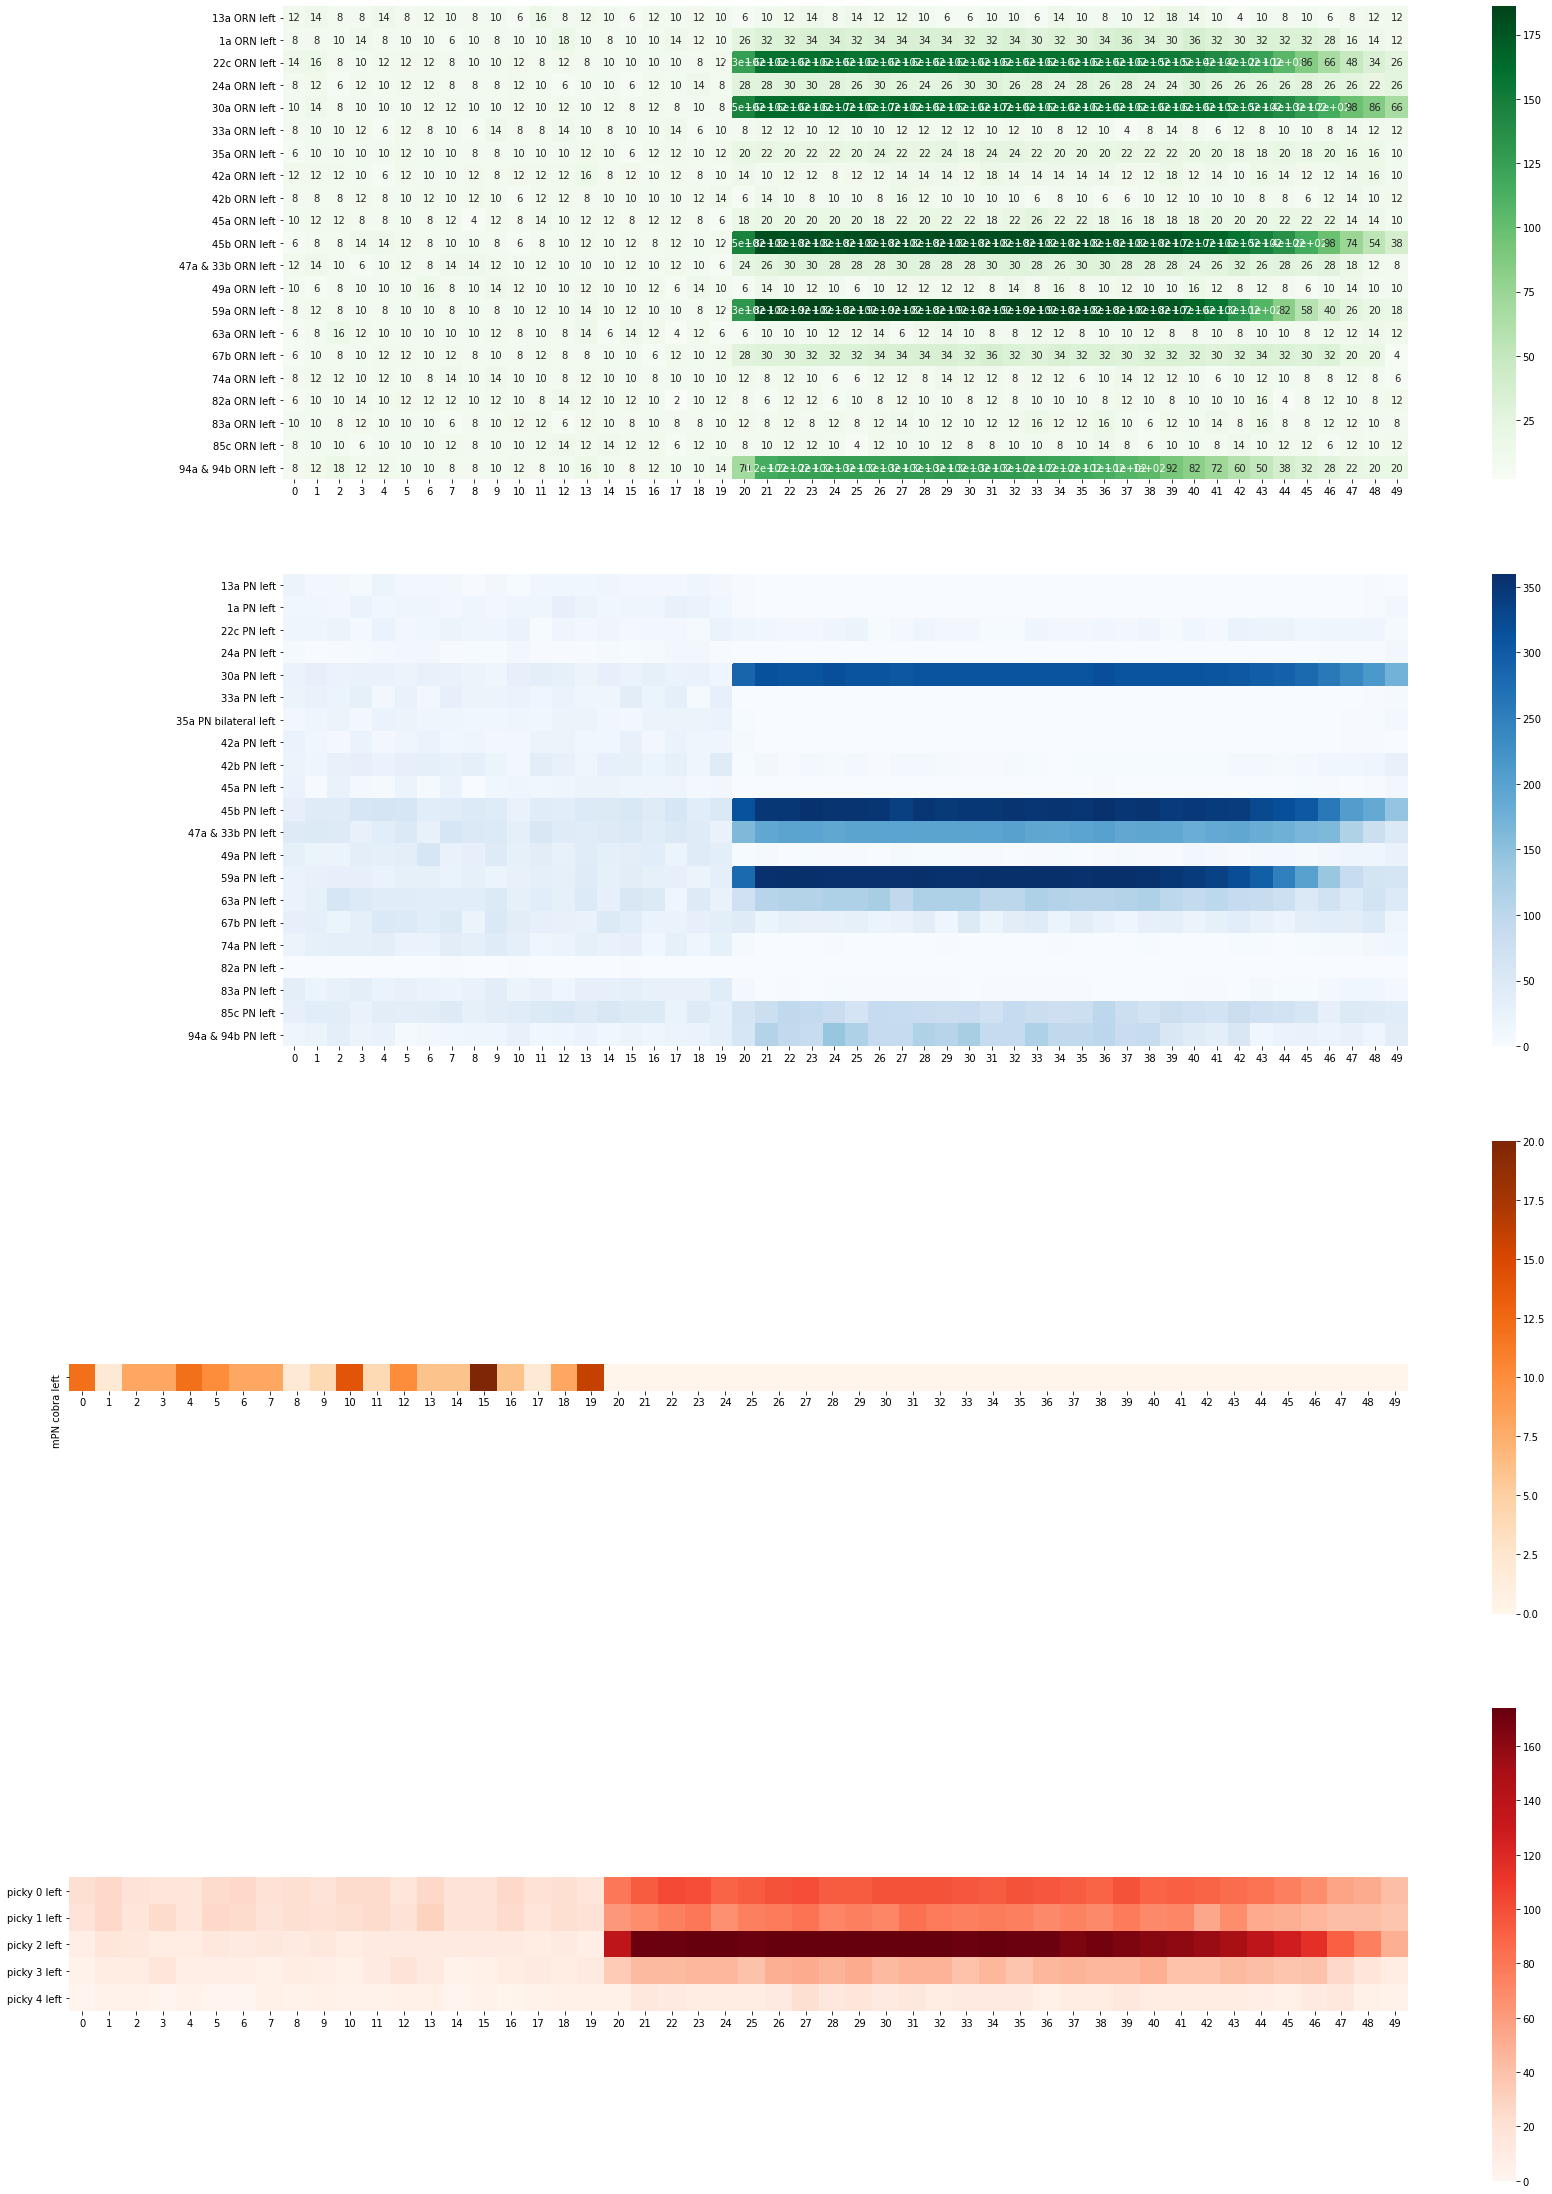

In [49]:
#plot single, cumulative heatmap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30,40))
title = 'Heatmap anisole'
sns.heatmap(responses_GA_ORN, cmap='Greens', xticklabels=np.arange(0, 50), yticklabels= ORNs_left, ax=ax1, square=True, annot=True)
sns.heatmap(responses_GA_uPN, cmap='Blues', xticklabels=np.arange(0, 50), yticklabels= uPNs_left, ax=ax2, square=True)
sns.heatmap(responses_GA_mPN, cmap='Oranges', xticklabels=np.arange(0, 50), yticklabels= mPNs_left, ax=ax3, square=True)
sns.heatmap(responses_GA_picky, cmap='Reds', xticklabels=np.arange(0, 50), yticklabels= Pickys_left, ax=ax4, square=True)
#plt.savefig('Firing_Rates_GA_allneurons_[-6]_Heatmap_dmel_connsparams4.png')
plt.show()

(0.0, 25.0)

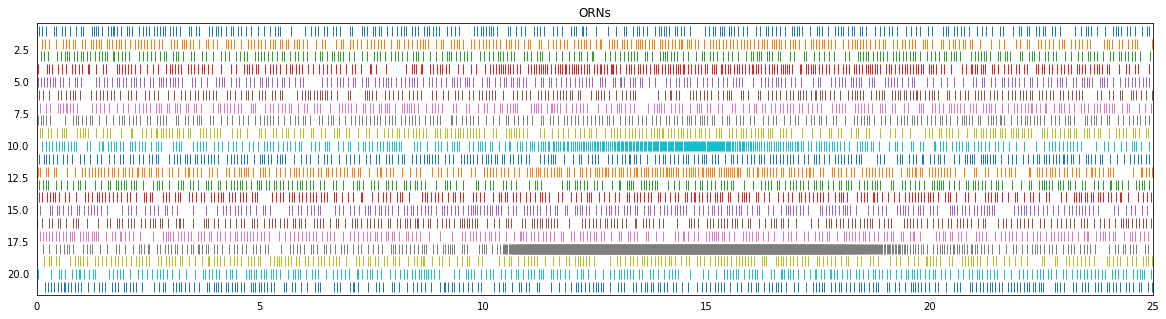

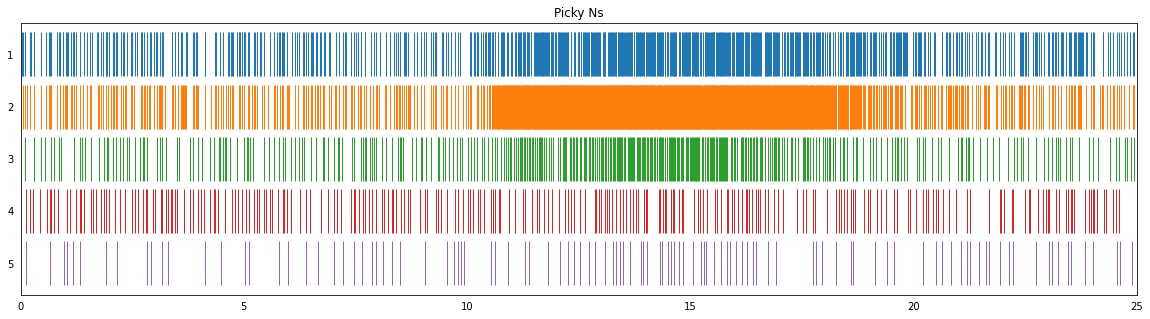

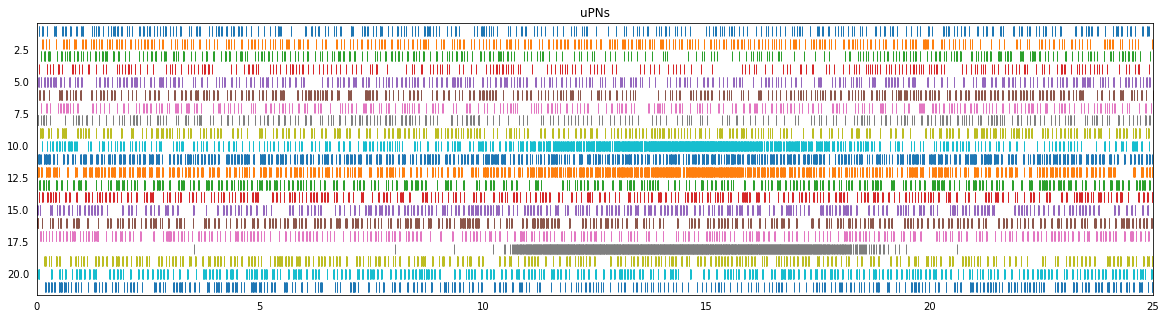

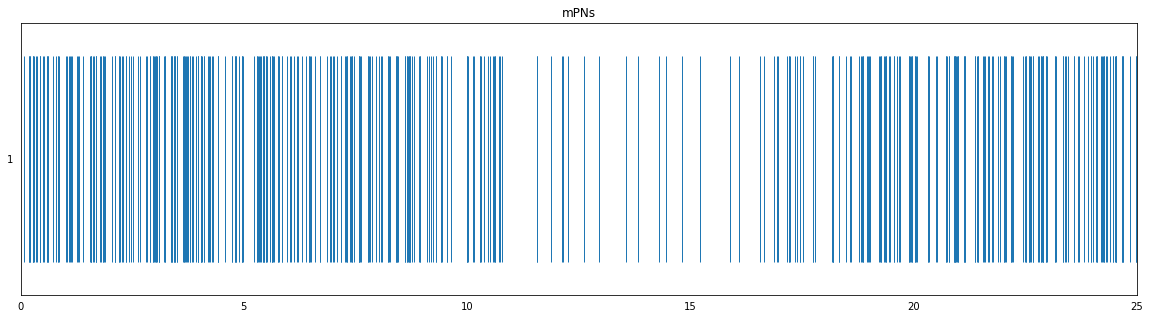

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

import nengo.utils.matplotlib

plt.figure(figsize=(20,5))
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_ORN])
plt.title('ORNs')
plt.xlim(0, 25)

plt.figure(figsize=(20,5))
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_Picky])
plt.title('Picky Ns')
#plt.plot(sim.trange(), sim.data[p_Picky][:,4])
plt.xlim(0, 25)

plt.figure(figsize=(20,5))
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_uPN])
plt.title('uPNs')
plt.xlim(0, 25)

plt.figure(figsize=(20,5))
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_mPN])
plt.title('mPNs')
plt.xlim(0, 25)


In [12]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model, cfg='picky.cfg')

Error during websocket communication.
Traceback (most recent call last):
  File "C:\Users\m3sky\anaconda3\lib\site-packages\nengo_gui\guibackend.py", line 276, in ws_default
    component.update_client(self.ws)
  File "C:\Users\m3sky\anaconda3\lib\site-packages\nengo_gui\components\netgraph.py", line 385, in update_client
    self.expand_network(network, client)
  File "C:\Users\m3sky\anaconda3\lib\site-packages\nengo_gui\components\netgraph.py", line 498, in expand_network
    self.create_connection(client, conn, parent=parent)
  File "C:\Users\m3sky\anaconda3\lib\site-packages\nengo_gui\components\netgraph.py", line 707, in create_connection
    kind = kind=NetGraph.connection_kind(conn)
  File "C:\Users\m3sky\anaconda3\lib\site-packages\nengo_gui\components\netgraph.py", line 624, in connection_kind
    trafo = trafo.sample()
  File "C:\Users\m3sky\anaconda3\lib\site-packages\nengo\transforms.py", line 596, in sample
    raise TypeError("Cannot sample a NoTransform")
TypeError: Cann